<a href="https://colab.research.google.com/github/liadekel/analyzing-big-data/blob/master/EX3_ClusteringMIMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
auth.authenticate_user()

In [4]:
import subprocess
import re

analysis_project = 'mimic-iii-71670'  #@param {type:"string"}

admissions_table = 'physionet-data.mimiciii_clinical.admissions'  # @param {type: "string"}
patients_table = 'physionet-data.mimiciii_clinical.patients'  # @param {type: "string"}
labs_table = 'physionet-data.mimiciii_clinical.labevents'  # @param {type: "string"}
d_labs_table = 'physionet-data.mimiciii_clinical.d_labitems'  # @param {type: "string"}
d_icd_diagnoses_table = 'physionet-data.mimiciii_clinical.d_icd_diagnoses'  # @param {type: "string"}
diagnoses_icd_table = 'physionet-data.mimiciii_clinical.diagnoses_icd'  # @param {type: "string"}

# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'analysis_project': analysis_project,
    'admissions_table': admissions_table,
    'patients_table': patients_table,
    'labs_table': labs_table,
    'd_labs_table': d_labs_table,
    'd_icd_diagnoses_table': d_icd_diagnoses_table,
    'diagnoses_icd_table': diagnoses_icd_table,
    'ml_table_prefix': analysis_project + '.MIMIC.models_'
}

# Set the default project for running queries
bigquery.magics.context.project = analysis_project

In [5]:
# Set up the substitution preprocessing injection
# if bigquery.magics._run_query.func_name != 'format_and_run_query':
#   original_run_query = bigquery.magics._run_query
original_run_query = bigquery.magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  return original_run_query(client, query, job_config)

bigquery.magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)

analysis_project: mimic-iii-71670

custom %%bigquery magic substitutions:
  {analysis_project} → mimic-iii-71670
  {admissions_table} → physionet-data.mimiciii_clinical.admissions
  {patients_table} → physionet-data.mimiciii_clinical.patients
  {labs_table} → physionet-data.mimiciii_clinical.labevents
  {d_labs_table} → physionet-data.mimiciii_clinical.d_labitems
  {d_icd_diagnoses_table} → physionet-data.mimiciii_clinical.d_icd_diagnoses
  {diagnoses_icd_table} → physionet-data.mimiciii_clinical.diagnoses_icd
  {ml_table_prefix} → mimic-iii-71670.MIMIC.models_


In [6]:
%config InlineBackend.figure_format = 'svg'

In [7]:
bq = bigquery.Client(project=analysis_project)

In [8]:
bq.project

'mimic-iii-71670'

In [9]:
if 'MIMIC' not in [d.dataset_id for d in list(bq.list_datasets())]:
  dataset_id = "{}.MIMIC".format(bq.project)
  # Construct a full Dataset object to send to the API.
  # Send the dataset to the API for creation.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.

  dataset = bigquery.Dataset(dataset_id)
  dataset = bq.create_dataset(dataset)  # Make an API request.

Create `KMEANS` model:

In [13]:
%%bigquery df
CREATE OR REPLACE MODEL `{ml_table_prefix}las_kmeans_clustering`
OPTIONS(
model_type='kmeans', kmeans_init_method='KMEANS++',
num_clusters=4, standardize_features=true
)
AS
WITH lab_count AS (
    SELECT COUNT(*) AS count, ITEMID FROM `{labs_table}`
    GROUP BY ITEMID
),
top_256_labs AS (
    SELECT lab_count.ITEMID, table_lookup.LABEL, lab_count.count
    FROM
        lab_count INNER JOIN
        `{d_labs_table}` AS table_lookup
        USING (ITEMID)
    # optimal m was 256
    ORDER BY count DESC LIMIT 256
)
SELECT
  HADM_ID,
  ADMITTIME,
  ETHNICITY,
  GENDER,
  INSURANCE,
  ADMISSION_LOCATION,
  ADMISSION_TYPE,
  MARITAL_STATUS,
  VALUE,
  VALUENUM,
  # MIMIC3 sets all ages over 89 to 300 to avoid the possibility of
  # identification.
  IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
  DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS AGE,
FROM
    (
    SELECT
    ANY_VALUE(adm.HADM_ID) as HADM_ID,
    ANY_VALUE(adm.ADMITTIME) as ADMITTIME,
    ANY_VALUE(adm.ADMISSION_LOCATION) as ADMISSION_LOCATION,
    ANY_VALUE(adm.ADMISSION_TYPE) as ADMISSION_TYPE,
    ANY_VALUE(diag.ITEMID) as ITEMID,
    MAX(diag.CHARTTIME) as CHARTTIME,
    AVG(VALUENUM) as VALUENUM,
    STRING_AGG(VALUE) as VALUE,
    ANY_VALUE(GENDER) as GENDER,
    ANY_VALUE(MARITAL_STATUS) as MARITAL_STATUS,
    ANY_VALUE(ETHNICITY) as ETHNICITY,
    ANY_VALUE(INSURANCE) as INSURANCE,
    ANY_VALUE(patients.DOB) as DOB
    FROM
        ((`{admissions_table}` AS adm
        INNER JOIN `{labs_table}` AS diag
        USING (HADM_ID, SUBJECT_ID))
        INNER JOIN `{patients_table}` AS patients
        USING (SUBJECT_ID))
        INNER JOIN top_256_labs
        USING (ITEMID)
    WHERE DATETIME_DIFF(diag.CHARTTIME, adm.ADMITTIME,  MINUTE) >= 0 AND
        DATETIME_DIFF(diag.CHARTTIME, adm.ADMITTIME, MINUTE) <= 60
    GROUP BY adm.HADM_ID, SUBJECT_ID, diag.ITEMID
    )

We can see the model `CETNROIDS`:

In [ ]:
%%bigquery 
SELECT * FROM ML.CENTROIDS(MODEL `{ml_table_prefix}las_kmeans_clustering`)

We can evaluate the model:

In [ ]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `{ml_table_prefix}las_kmeans_clustering`)

Model examination shows the distribution of each demographic feature:


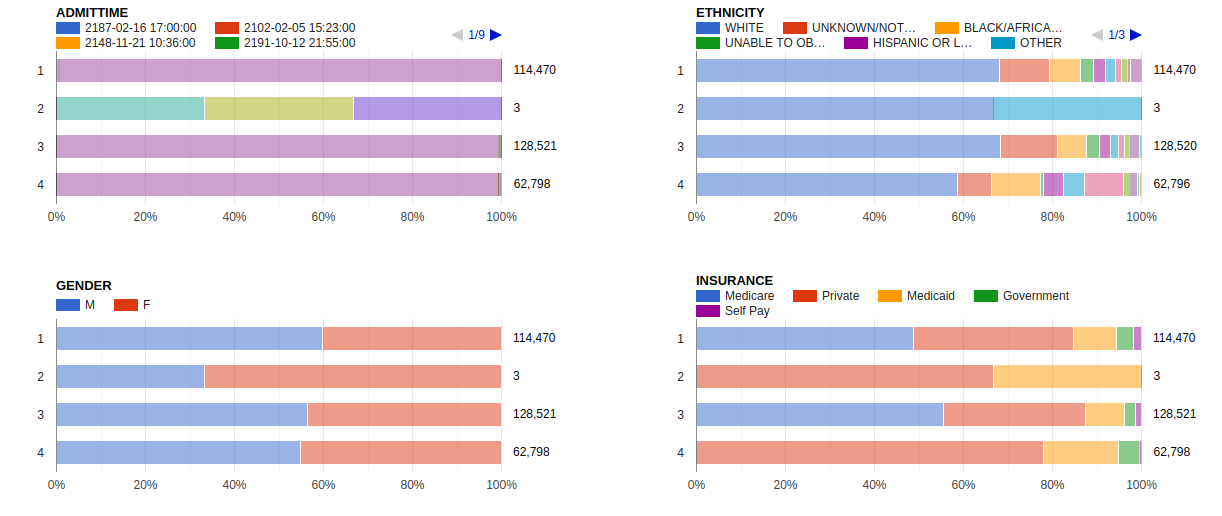

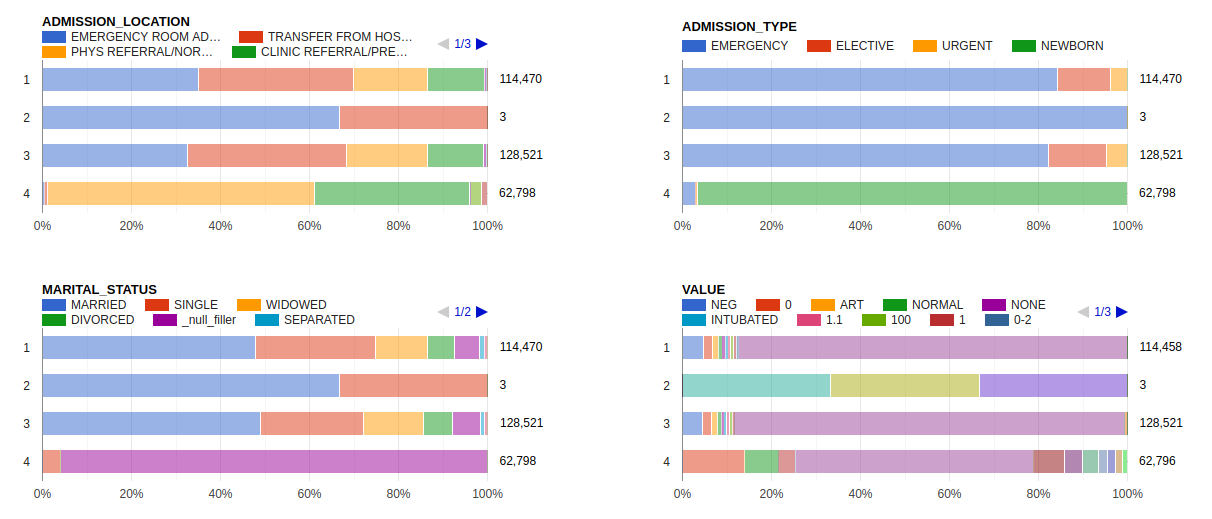

In order to answer death probability questions we will need to add `DIED` feature as well.

We'll start by calculating the general death probability:

In [25]:
%%bigquery death_prob_df
SELECT
    AVG(HOSPITAL_EXPIRE_FLAG) as death_prob
FROM `{admissions_table}` AS adm

In [26]:
death_prob = death_prob_df['death_prob'][0]
print(f'general death prob is {death_prob}')

general death prob is 0.09926071622354933


Added the `DIED` feature:

In [22]:
%%bigquery df_death
CREATE OR REPLACE MODEL `{ml_table_prefix}las_kmeans_clustering_death`
OPTIONS(
model_type='kmeans', kmeans_init_method='KMEANS++',
num_clusters=4, standardize_features=true
)
AS
WITH lab_count AS (
    SELECT COUNT(*) AS count, ITEMID FROM `{labs_table}`
    GROUP BY ITEMID
),
top_256_labs AS (
    SELECT lab_count.ITEMID, table_lookup.LABEL, lab_count.count
    FROM
        lab_count INNER JOIN
        `{d_labs_table}` AS table_lookup
        USING (ITEMID)
    # optimal m was 256
    ORDER BY count DESC LIMIT 256
)
SELECT
  HADM_ID,
  ADMITTIME,
  ETHNICITY,
  GENDER,
  INSURANCE,
  ADMISSION_LOCATION,
  ADMISSION_TYPE,
  MARITAL_STATUS,
  VALUE,
  VALUENUM,
  # MIMIC3 sets all ages over 89 to 300 to avoid the possibility of
  # identification.
  IF(DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25 < 200,
  DATETIME_DIFF(ADMITTIME, DOB, DAY)/365.25, 95) AS AGE,
  DIED
FROM
    (
    SELECT
    ANY_VALUE(adm.HADM_ID) as HADM_ID,
    ANY_VALUE(adm.ADMITTIME) as ADMITTIME,
    ANY_VALUE(adm.ADMISSION_LOCATION) as ADMISSION_LOCATION,
    ANY_VALUE(adm.ADMISSION_TYPE) as ADMISSION_TYPE,
    ANY_VALUE(diag.ITEMID) as ITEMID,
    MAX(diag.CHARTTIME) as CHARTTIME,
    AVG(VALUENUM) as VALUENUM,
    STRING_AGG(VALUE) as VALUE,
    ANY_VALUE(GENDER) as GENDER,
    ANY_VALUE(MARITAL_STATUS) as MARITAL_STATUS,
    ANY_VALUE(ETHNICITY) as ETHNICITY,
    ANY_VALUE(INSURANCE) as INSURANCE,
    ANY_VALUE(patients.DOB) as DOB,
    MAX(adm.HOSPITAL_EXPIRE_FLAG) as DIED
    FROM
        ((`{admissions_table}` AS adm
        INNER JOIN `{labs_table}` AS diag
        USING (HADM_ID, SUBJECT_ID))
        INNER JOIN `{patients_table}` AS patients
        USING (SUBJECT_ID))
        INNER JOIN top_256_labs
        USING (ITEMID)
    WHERE DATETIME_DIFF(diag.CHARTTIME, adm.ADMITTIME,  MINUTE) >= 0 AND
        DATETIME_DIFF(diag.CHARTTIME, adm.ADMITTIME, MINUTE) <= 60
    GROUP BY adm.HADM_ID, SUBJECT_ID, diag.ITEMID
    )

In [ ]:
lly

We can see how the clusters are evaluated in the schema below.

The `DIED` column is especially interesting related to death question.
As we can see the probability of death in cluster `1` is 0.1 while in cluster `2` it's 0.33. `3` and `4` are 1 (everyone died) and 0 (no one died) respectivley.

**NOTE**: The general probability to die was 0.09

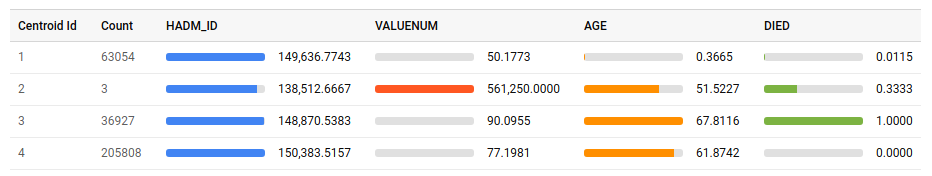